# Identifying Basic Shapes w/ QuickDraw Data
**My first neural network!** (besides messing around with Andrew Ng's MNIST network). We're going to make a **basic neural network that inputs a drawing of a basic shape and identifies it**. This is a nice idea because it's not a typical project like MNIST where it feels like everything is laid out and the actions to take are clear cut; no preprocessing, no contemplating between approaches, etc.

The only obstacle with this project is the data, I was lost on what to do with the data. Thankfully, I had an amazing idea during the Google workshop when I was at ShellHacks '23. **Google QuickDraw** provides us access to a large amount of basic drawings. We can pull out the images of basic shapes from this data, and train a model on identifying them. **We have 5 shapes (classes), and these are: triangle, square, circle, star, and line.**

Let's get started!

In [14]:
from sklearn.model_selection import train_test_split
from math import radians, sqrt, sin, cos
from collections import defaultdict
from sklearn.utils import shuffle
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from copy import deepcopy
import tensorflow as tf
from time import time
import numpy as np
import datetime
import requests
import random
import json
import os

### Constants and File Paths

In [15]:
RAW_DATA_PATH = "raw_data_recognized/{}.ndjson"
# DATA_PATH = "data/{}.png"  # for when I want to store final processed data

RAND_STATE_VAL = 169

random.seed(time()**2)

## Shapes/Classes to Identify
Below are the classes from QuickDraw that are basic shapes, this is what we want to train our neural network on.

### Class Reduction
**Initially, we had 7 classes/basic shapes, the missing 2 were hexagons and octagons.** After analysis/exploration of the images from all the classes, I realized that the hexagon and octagon images are kinda terrible. I could still go for it because neural networks are very good at learning the nuanced differences, and we have lots of images, but the images are just so terrible that I would not even consider most of them to be hexagons or octagons; like the class doesn't even really exist in my eyes. This is a completely okay change, it doesn't diminish the quality of the project or make it less cool; if anything it's an improvement in many ways.

I am talking pretty bad about the images, but in reality they do have lots of potential. I'm just going to leave them out for now, but **in the future I'm definitely going to work on identifying them as well.**

In [16]:
# Define classes of shapes
classes = ['triangle', 'square', 'circle', 'star', 'line']  # 'hexagon', 'octagon',

# Data Collection
As described above, we're going to be using data from QuickDraw, Google's pretty cool AI. We have a function below that downloads the data to newline delimited JSON files. The data consists of many thousands of drawings drawn by users, and each one includes a tag indicating whether's Google AI was able to recognize the drawing. Lots of the unrecognized drawings don't match the class, because users are silly, so very simply we're going to get rid of those unrecognized images. To separate the recognized images, we have a function to deep copy the dataset, including only images that have been recognized by Google's AI.

## Downloading the Dataset

In [17]:
def download_quickdraw_data(shape, save_path=RAW_DATA_PATH):
    """ Downloads QuickDraw (raw unprocessed) data of given shape. """

    url = f'https://storage.googleapis.com/quickdraw_dataset/full/simplified/{shape}.ndjson'

    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise an error if the request failed

    with open(save_path.format(shape), 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

def duplicate_recognized_data(src_folder: str, dst_folder: str):
    """ Makes a deepcopy of the data that was recognized. """

    # Ensure destination folder exists
    if not os.path.exists(dst_folder):
        os.makedirs(dst_folder)

    # List all files in source folder
    files = [f for f in os.listdir(src_folder) if os.path.isfile(os.path.join(src_folder, f)) and f.endswith('.ndjson')]

    # Process each file
    for filename in files:
        src_file_path = os.path.join(src_folder, filename)
        dst_file_path = os.path.join(dst_folder, filename)

        # Open source and destination files
        with open(src_file_path, 'r') as source_file, open(dst_file_path, 'w') as dest_file:
            for line in source_file:
                data = json.loads(line)
                if data['recognized']:
                    dest_file.write(line)

    print('deep copy process completed!')

def load_raw_data(shape_class: str, save_ids: bool = False, load_amount: int = None) -> list:
    """ Loads (recognized) drawings, w/ IDs if desired, from given shape raw data. """

    # Lambda function for pulling values from line of data (option to save IDs)
    pull_values = ((lambda dataline: dataline['drawing']) if save_ids is False
                else (lambda dataline: (dataline['key_id'], dataline['drawing'])))

    load_file =  open(RAW_DATA_PATH.format(shape_class), 'r')
    lines_loaded = 0
    drawings = []

    for line in load_file:
        # Stop reading once we've reached the load_amount (if limit exists)
        if load_amount is not None and lines_loaded >= load_amount:
            break

        data = json.loads(line)

        # Only save drawing if it was recognized
        if data['recognized'] is True:
            drawings.append(pull_values(data))
            lines_loaded += 1  # only count lines w/ recognized drawings

    load_file.close()

    return drawings

In [18]:
# Iterate through shapes/classes and download each one's QuickDraw data
""" for shape in classes:
    print(f'downloading {shape} data...')
    download_quickdraw_data(shape) """;

## Dataset Size/Split
We have quite a **massive dataset** (thank you Google), even though it's just 5 classes out of the 345 total classes 🤯

The images have an attribute stating whether it was recognized by the QuickDraw AI. **We're only going to use images that were recognized**, because the unrecognized mostly don't look like the shape they're supposed to be lol.

In [19]:
# Counts the number of recognized images in each class and saves to variable

class_sizes = {}
total_count = 0

print('Dataset Size of Each Shape\n')

for shape in classes:
    with open(RAW_DATA_PATH.format(shape), 'r') as ndjson_infile:
        line_count = sum(1 for _ in ndjson_infile)

    class_sizes[shape] = line_count
    total_count += line_count
    print(f'{shape}: {line_count:,}')

print(f'\ntotal: {total_count:,}')

Dataset Size of Each Shape

triangle: 120,500
square: 120,538
circle: 118,808
star: 132,814
line: 140,874

total: 633,534


## Class Data Sizes
According to the computation above, we have a whopping **633,534 images (more than half a million)**, which is an **average of ~127 thousand images per shape**.

| Shape    | Count   |
|----------|---------|
| triangle | 120,500 |
| square   | 120,538 |
| circle   | 118,808 |
| star     | 132,814 |
| line     | 140,874 |
| **total**| 633,534 |

## Data Split Configuration
Per ChatGPT's advice, we're going to start with **10% of the dataset (~63 thousand images)**, making it **easier to handle** while we're tuning the model; this is still a substantial amount of data. Because each class has different sizes, we're going to use a constant number of images from each class instead of a percentage, to make the balance perfectly equal. We're basing the number off of the smallest class' size, which is the circle set. It has nearly 119 thousand images, so **we're going to use exactly 12 thousand images from each class, which is approximately 10% of the class size**.

Putting it back together, our data subset contains **60,000 images** out of the 633,534 total.  
With ChatGPT's help, here is the data split we settled on:
| Dataset   | Ratio | Size   | Per class |
|-----------|:-----:|:------:|:----------|
|Training   | 50%   | 30,000 | 6,000     |
|Validation | 25%   | 15,000 | 3,000     |
|Testing    | 25%   | 15,000 | 3,000     |
| **Total** | 100%  | 60,000 | 12,000    |


In [20]:
CLASS_SIZE = 12_000  # 12,000 images = ~10% of the data
raw_data = {}

# For every shape class, load the first ~10% of the raw data and shuffle it
for shape in classes:
    data = load_raw_data(shape, load_amount=CLASS_SIZE)  # Load only CLASS_SIZE drawings
    raw_data[shape] = shuffle(data, random_state=RAND_STATE_VAL)  # Shuffle loaded data

""" Structure of the data
For any raw_data[shape] and when it's all combined later,
the data is a list, where each element are the strokes for a drawing:
[
    drawing_123_stroke_data,
    drawing_124_stroke_data,
    drawing_125_stroke_data,
    ...
]
""";  # <- semicolon prevents block comment from printing

In [21]:
# Create train, validation, and test sets that hold all data across classes
X_train, X_valid, X_test = [], [], []
y_train, y_valid, y_test = [], [], []

# Split each class' dataset separately
for shape in classes:
    X = raw_data[shape]
    y = [shape] * len(X)

    # First split off train set, then split remainder into validation and test sets
    tmp_X_train, X_temp, tmp_y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=RAND_STATE_VAL)
    tmp_X_valid, tmp_X_test, tmp_y_valid, tmp_y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RAND_STATE_VAL)

    # Add newly split class set to datasets
    X_train.extend(tmp_X_train)
    X_valid.extend(tmp_X_valid)
    X_test.extend(tmp_X_test)

    y_train.extend(tmp_y_train)
    y_valid.extend(tmp_y_valid)
    y_test.extend(tmp_y_test)

# Shuffle datasets
X_train, y_train = shuffle(X_train, y_train, random_state=RAND_STATE_VAL)
X_valid, y_valid = shuffle(X_valid, y_valid, random_state=RAND_STATE_VAL)
X_test, y_test = shuffle(X_test, y_test, random_state=RAND_STATE_VAL)

In [22]:
print(f'X_train length: {len(X_train):,}')
print(f'X_valid length: {len(X_valid):,}')
print(f'X_valid length: {len(X_valid):,}')
print(f'Total Dataset Size: {len(X_train)+len(X_valid)+len(X_valid):,}')

X_train length: 30,000
X_valid length: 15,000
X_valid length: 15,000
Total Dataset Size: 60,000


# Data Preprocessing
Now that we have our data, we can begin the long process of preprocessing it. To start this, let's randomly pull some drawings and display them!

In [23]:
# Shape drawing/image generation

def convert_strokes_to_image(data, stroke_width=3):
    """ Converts stroke data to an image using PIL at its full resolution, or resize if desired. """

    # Compute the bounds of the stroke data to determine the size of the image.
    min_x = min([min(stroke[0]) for stroke in data])
    max_x = max([max(stroke[0]) for stroke in data])
    min_y = min([min(stroke[1]) for stroke in data])
    max_y = max([max(stroke[1]) for stroke in data])

    # Shift everything into the positive space
    width, height = int(max_x - min_x + 1), int(max_y - min_y + 1)

    # Initialize a blank white image
    image = Image.new("RGB", (width, height), "white")
    draw = ImageDraw.Draw(image)

    for stroke in data:
        for i in range(len(stroke[0]) - 1):
            x0, y0 = stroke[0][i] - min_x, stroke[1][i] - min_y
            x1, y1 = stroke[0][i + 1] - min_x, stroke[1][i + 1] - min_y
            draw.line([(x0, y0), (x1, y1)], fill="black", width=stroke_width)

    return image

def display_multiple_drawings(shape: str = None, dimensions: tuple = (3, 5)):
    """ Displays a grid of many drawings based on given arguments. """

    # this enables us to avoid checking if a shape is given every iteration
    get_shape = (lambda: shape) if shape is not None else (lambda: random.choice(classes))

    rows, cols = dimensions
    _, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

    # for 1 dimensional plots
    if rows == 1 or cols == 1:
        axes = [axes]

    for r in range(rows):
        for c in range(cols):
            _, random_drawing = random_shape_from_class(get_shape())
            image = convert_strokes_to_image(random_drawing)
            ax = axes[r][c]
            ax.imshow(image)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

In [24]:
# Shape retrieval from data

def random_shape_from_class(shape_class: str) -> (str, list):
    """ Gets random shape from given shape class and returns its drawing and ID. """
    random_line_index = random.randint(0, class_sizes[shape_class] - 1)
    with open(RAW_DATA_PATH.format(shape_class), 'r') as file:
        for current_index, line in enumerate(file):
            if current_index == random_line_index:
                data = json.loads(line)
                return data['key_id'], data['drawing']

def fetch_shape_drawing(shape_class: str, shape_id: str) -> list:
    """ Fetches shape drawing of given ID from given shape class. """
    with open(RAW_DATA_PATH.format(shape_class), 'r') as file:
        for line in file:
            if json.loads(line)['key_id'] == shape_id:
                return json.loads(line)['drawing']

In [25]:
# # Selects a single random shape drawing and display its
# choose_shape = 'star'# <- edit shape here
# drawing_id, random_drawing = random_shape_from_class(choose_shape)

# original = convert_strokes_to_image(random_drawing)
# resized = convert_strokes_to_resized_image(random_drawing, target_size=(48,48))

# # Original image
# print(drawing_id)
# plt.imshow(original)
# plt.axis('off')  # Hide axes
# plt.show()

# # Resized
# plt.imshow(resized)
# plt.axis('off')  # Hide axes
# plt.show()

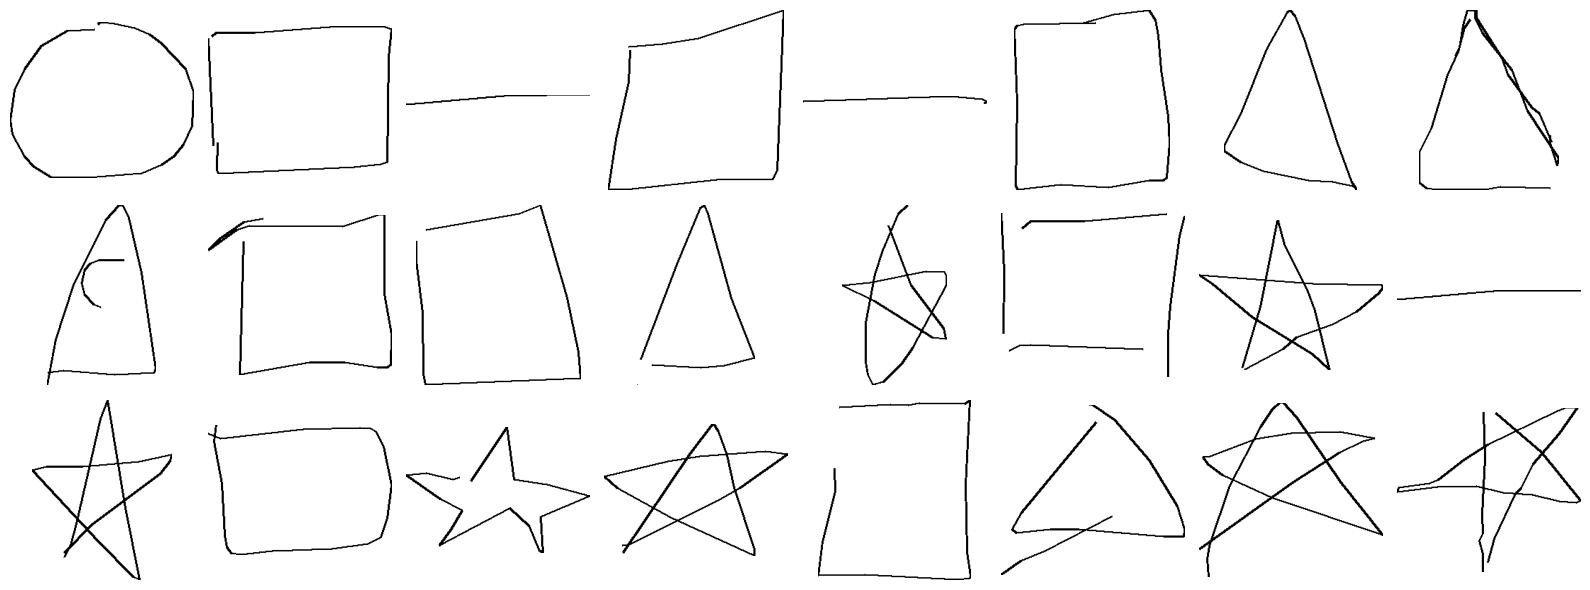

In [26]:
# Selects multiple random shapes/drawings and displays them all
display_multiple_drawings(dimensions=(3, 8))

## Data Augmentation
While flipping through the dataset, one that becomes apparent is that everyone has the same idea when drawing triangles: the base is parallel to the bottom. I looked through 150+ images before I found a triangle drawing facing a different direction, and it'd probably take me even longer to find the next one. Basic hand drawn shapes should be a relatively unconvoluted task for the neural network to learn, but despite this, I still think the property observed above might throw the neural network off.

This issue isn't difficult to address, all it takes is **data augmentation**. Very simply, we need to generate a few rotations of each image and add them to the dataset. This way, the neural network is exposed to different orientations of shapes, ensuring it can easily identify a triangle even if it's "upside down".

Likely not every shape will need to be rotated, or at least not rotated as many times as some other shapes will need. For example, a triangle rotated either 45° or 90°, however many times, looks different. On the other hand a square rotated 90° looks the same but rotated 45° looks very different. We're going to limit the smallest rotation to an increment of 45°, any more would be unnecessary and just pollute the dataset. Let's not forget that neural networks are still pretty smart, they can figure it out 🧠😎.

To decide how many augmentations each shape will need, we're going to observe each shape rotated at 45° increments and see if we can deduce anything interesting.

In [27]:
# Shape/image rotation

def rotate_point(x: int, y: int, angle: int) -> (int, int):
    """ Rotate a single point (coord) around the origin by a given angle in degrees. """
    rad_angle = radians(angle)
    x_rot = cos(rad_angle) * x - sin(rad_angle) * y
    y_rot = sin(rad_angle) * x + cos(rad_angle) * y
    return x_rot, y_rot

def rotate_strokes(strokes: list, angle: int) -> list:
    """ Rotate a series of strokes by a given angle in degrees and returns the rotated strokes. """

    if angle == 0:
        return strokes

    rotated_strokes = []

    for stroke in strokes:
        x_coords, y_coords = stroke
        new_x_coords, new_y_coords = [], []

        for x, y in zip(x_coords, y_coords):
            new_x, new_y = rotate_point(x, y, angle)
            new_x_coords.append(new_x)
            new_y_coords.append(new_y)

        rotated_strokes.append([new_x_coords, new_y_coords])

    return rotated_strokes

def demo_shape_rotations(axs, shape_drawing: list):
    """ Displays given shape drawing on axs plot in rotations of 45°. """
    # First displays right angle views, then diagonal views
    for i, angle in enumerate(list(range(0, 360, 90)) + list(range(45, 405, 90))):
        rotated_strokes = rotate_strokes(shape_drawing, angle)
        image = convert_strokes_to_image(rotated_strokes)
        axs[i].imshow(image)
        axs[i].set_title(f'{angle}°')
        axs[i].axis('off')

# def agabooiye(axs, shape_drawing: list, dim):
#     """ Displays given shape drawing on axs plot in rotations of 45°. """
#     # First displays right angle views, then diagonal views
#     for i, angle in enumerate(list(range(0, 360, 90)) + list(range(45, 405, 90))):
#         rotated_strokes = rotate_strokes(shape_drawing, angle)
#         image = convert_strokes_to_resized_image(rotated_strokes, target_size=(dim, dim))
#         axs[i].imshow(image)
#         axs[i].set_title(f'{angle}°')
#         axs[i].axis('off')

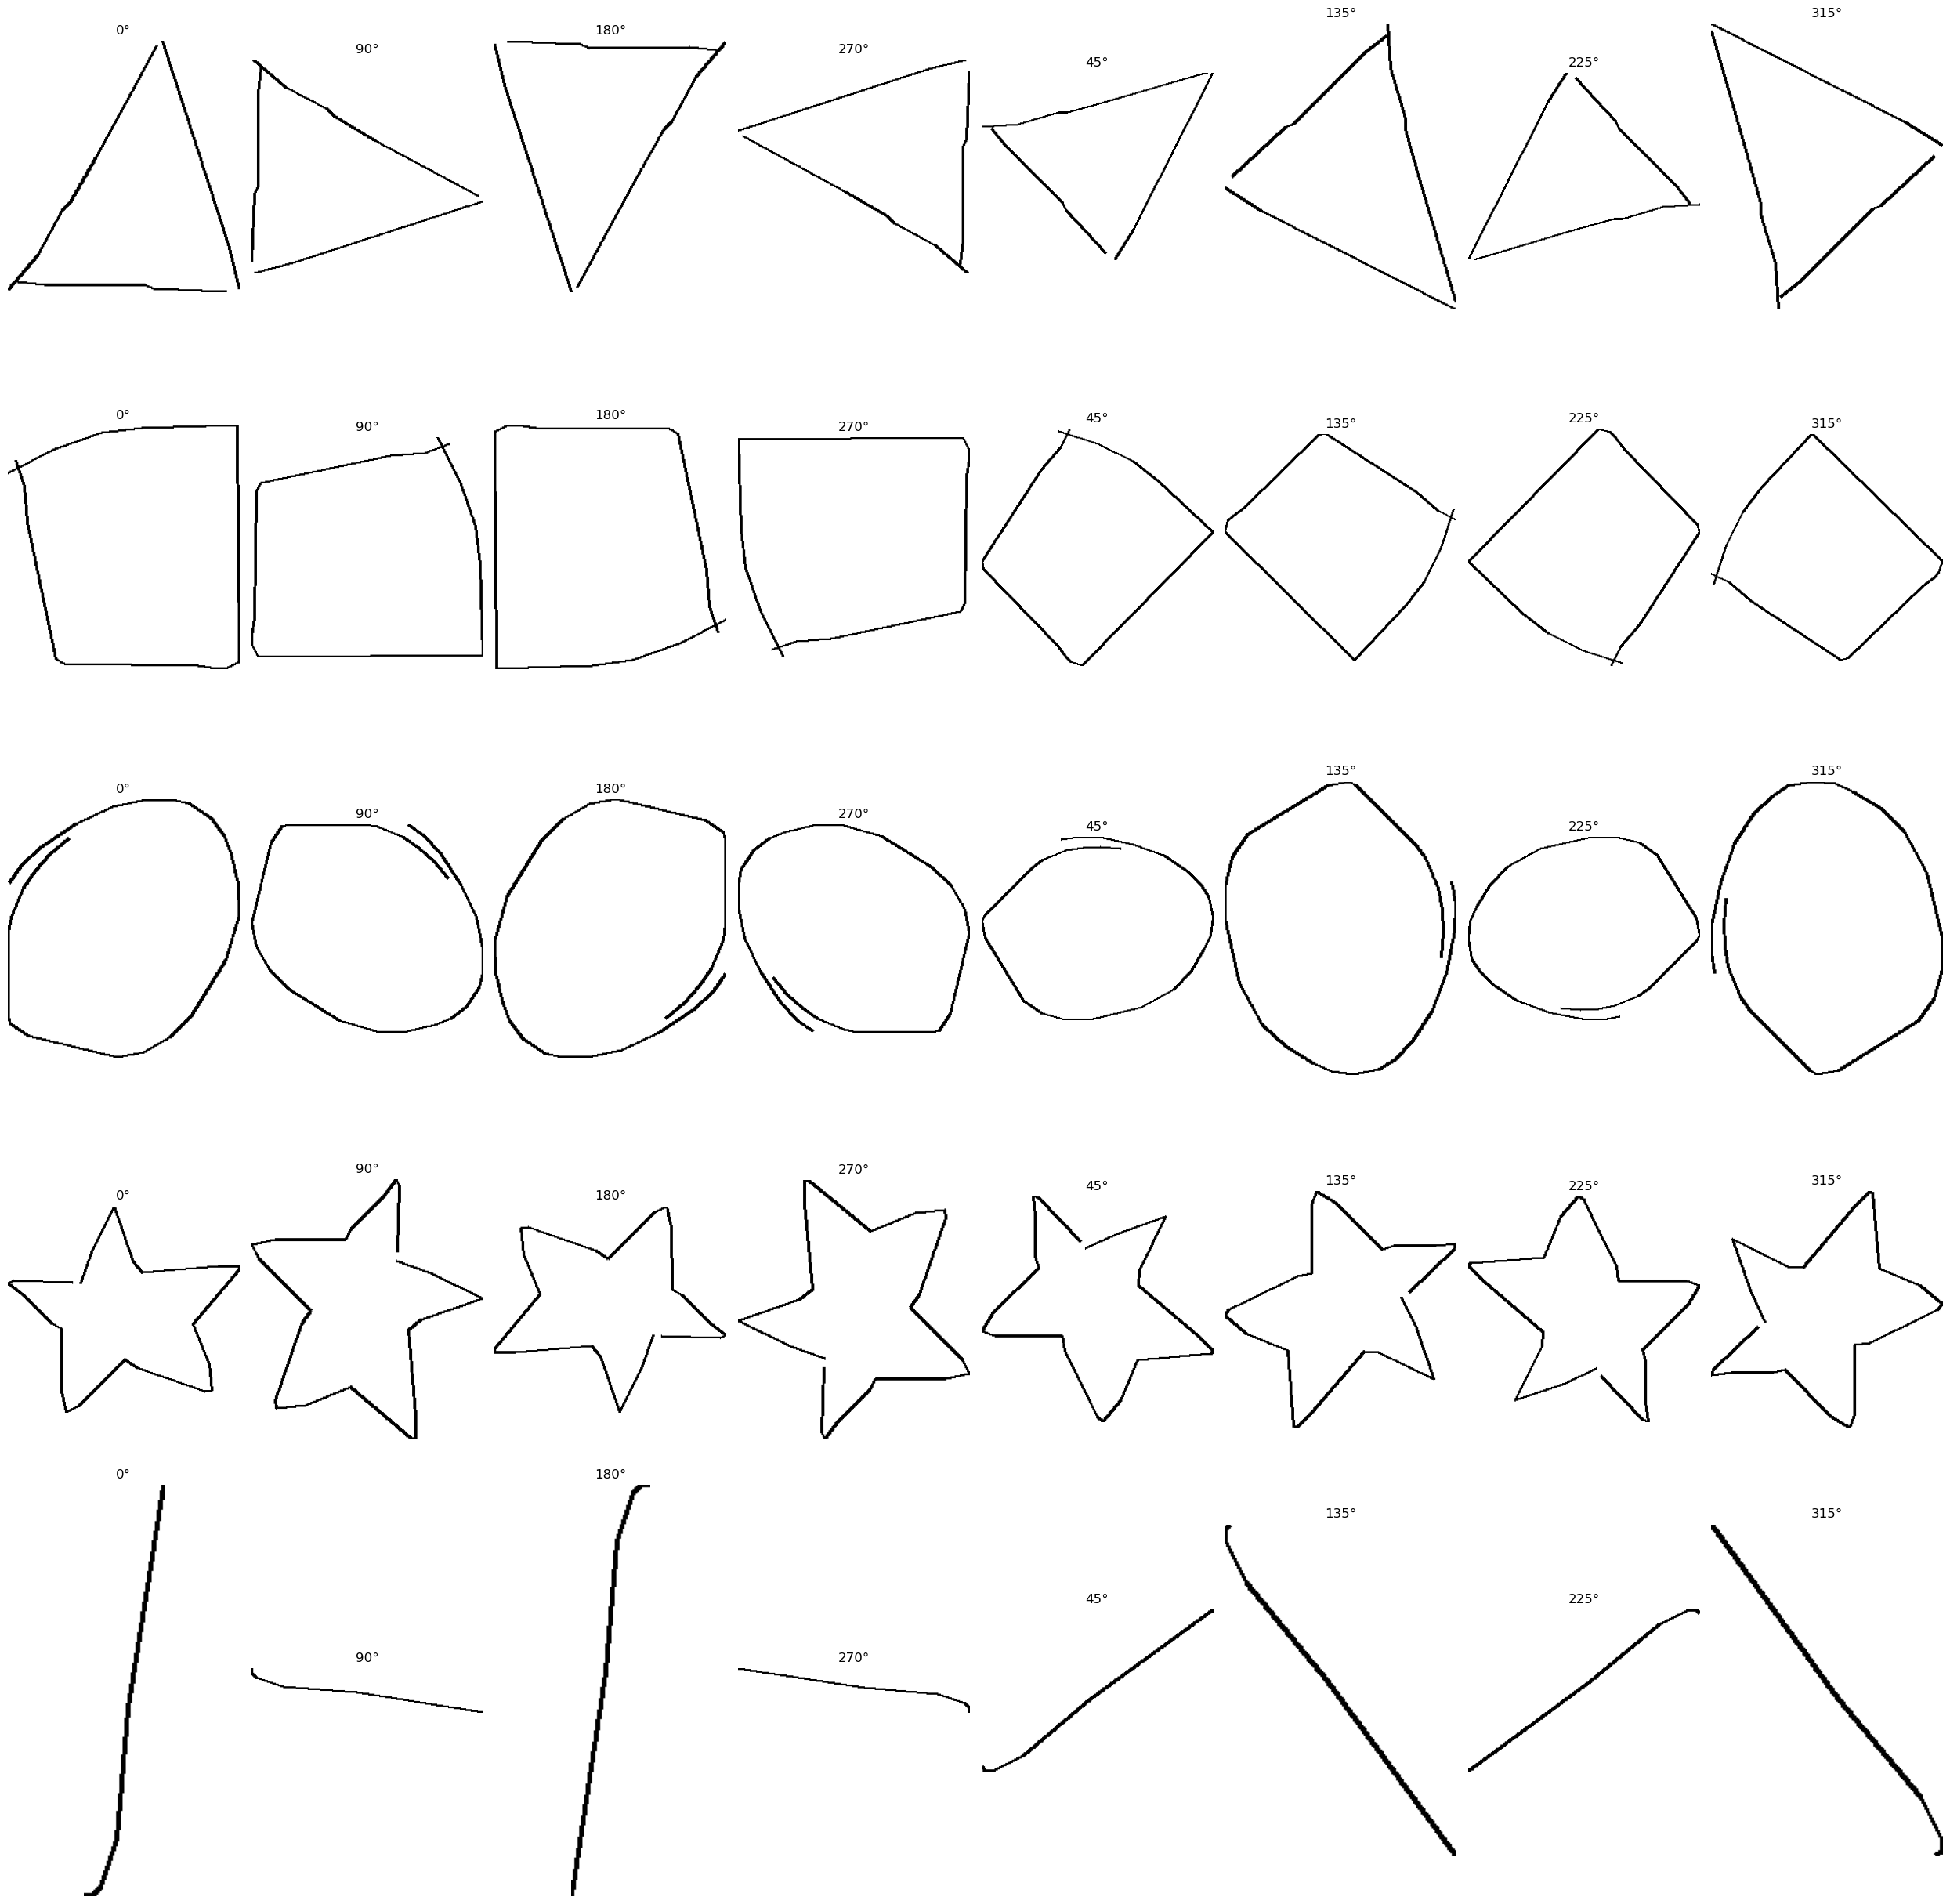

In [28]:
# Display rotation demo of every shape for analysis

# Main display code
fig = plt.figure(figsize=(25, 25))

# Create the grid for the 5 shape, each shape occupies a row
gs = fig.add_gridspec(5, 8)  # 5 rows, 8 columns

shape_drawings = [
    ('5967556856774656', 'triangle'),
    ('5966988780240896', 'square'),
    ('5371214920941568', 'circle'),
    ('5032342252945408', 'star'),  # empty star
    # 5445255157514240             # not empty, start with OG lines
    ('6718965944418304', 'line')
]

for i, (shape_id, shape_class) in enumerate(shape_drawings):
    axs = [fig.add_subplot(gs[i, j]) for j in range(8)]
    drawing = fetch_shape_drawing(shape_class, shape_id)
    demo_shape_rotations(axs, drawing)

plt.tight_layout()
plt.show()

Below are more functions that are some variation of displaying a bunch of shapes. To decide on how I want to tackle the lack of variation, I just need to stare at hundreds of random drawings of shapes until I'm satisfied lol. One observation I made while observing the images is that I felt like 45° square rotation isn't enough, so I experimented with 30° and 60°.

In [29]:
# == Displays of Rotated Shapes ==
def display_multiple_drawing_rotations(shape: str = None, dimensions: tuple = (3, 5), angle: int = 45):
    """ Displays a grid of many drawings with multiple varying rotations based on given arguments. """

    # this enables us to avoid checking if a shape is given every iteration
    get_shape = (lambda: shape) if shape is not None else (lambda: random.choice(classes))

    rows, cols = dimensions
    _, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

    # for incrementing angle
    count = 0

    # for 1 dimensional plots
    if rows == 1 or cols == 1:
        axes = [axes]

    for r in range(rows):
        for c in range(cols):
            random_drawing = random_shape_from_class(get_shape())[1]
            random_drawing = rotate_strokes(random_drawing, angle*count)
            count += 1  # increment angle multiplier
            image = convert_strokes_to_image(random_drawing)
            ax = axes[r][c]
            ax.imshow(image)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

def display_multiple_rotated_drawings(shape: str = None, dimensions: tuple = (3, 5), angle: int = 45):
    """ Displays a grid of many drawings all rotated the same angle based on given arguments. """

    # this enables us to avoid checking if a shape is given every iteration
    get_shape = (lambda: shape) if shape is not None else (lambda: random.choice(classes))

    rows, cols = dimensions
    _, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

    # for 1 dimensional plots
    if rows == 1 or cols == 1:
        axes = [axes]

    for r in range(rows):
        for c in range(cols):
            random_drawing = random_shape_from_class(get_shape())[1]
            random_drawing = rotate_strokes(random_drawing, angle)
            image = convert_strokes_to_image(random_drawing)
            ax = axes[r][c]
            ax.imshow(image)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

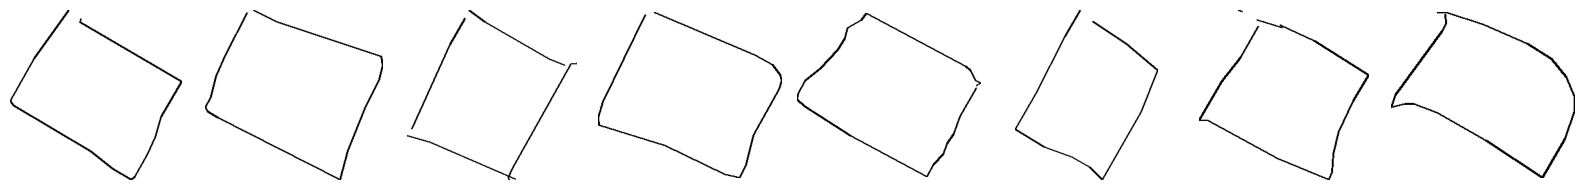

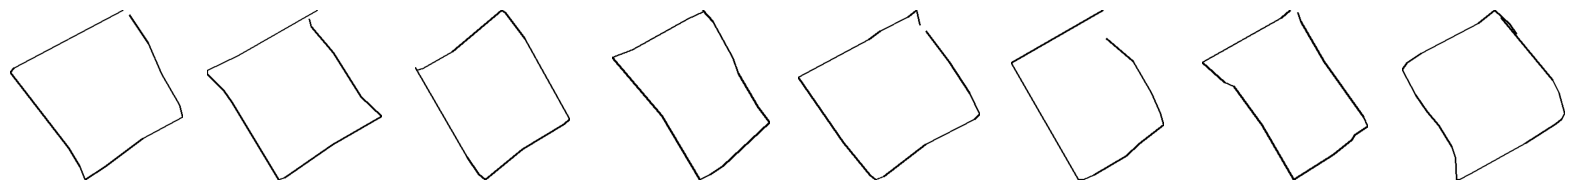

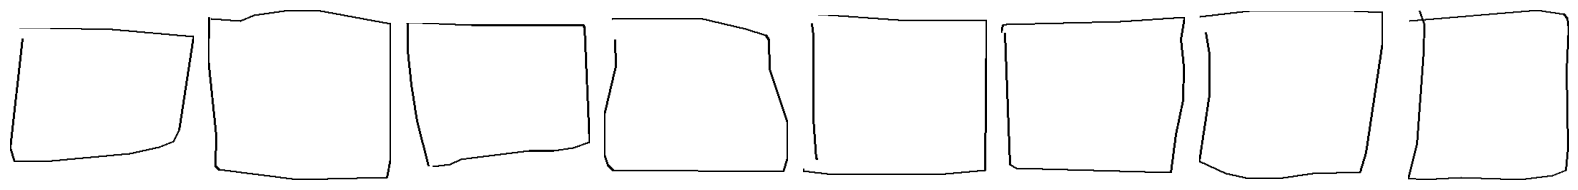

In [30]:
# Square at 30° and 60° rotations
display_multiple_rotated_drawings('square', dimensions=(1, 8), angle=30)
display_multiple_rotated_drawings('square', dimensions=(1, 8), angle=60)
display_multiple_drawings('square', dimensions=(1, 8))

# NOTE: we previously had the idea of using half a "part" of 30° rotated and half 60° rotated, but ditched it

## Rotation (data augmentation cont.)
Looking at the images above, we can extrapolate many interesting details. But before we do that, let's explain what these rotations tell us.

Initially we noticed that nearly all the triangles are orientated in one direction. This could be an issue because if I was to draw a triangle that looks like the 135° rotated triangle, my final model may not be able to tell it's a triangle, as a result of only seeing triangles pointing upwards in training. This is what I'm going to call a **problem of variety**, as in there's a lack of variety of orientations in the triangle drawings.

**To combat this problem,** we very simply need to fill this absence with drawings in different orientations. The thing is, not every shape has this problem. Take the star for example. When rotated it provides some variation, but if you looked at the rest of the star dataset you'd realize that variation already exists. In the star's case, we wouldn't need to generate any rotated drawings. Let's look at one more shape, the square. The square looks the same in the right angle/upright orientations, however when it comes to the diagonals (45° orientations), it clearly looks different. More precisely, the diagonals look different relative only to the upright squares, but look the same compared to other diagonals. So for the square, we would only need to rotate each drawing 45° once, maybe a smaller angle as well.

Below are the rotations/copies each shape requires to have complete variation (does not include the original orientation).

| Shape    | Rotations          |
|----------|--------------------|
| triangle | +7: full range 45° |
| square   | +3: 30°, 45°, 60°  |
| circle   | +0: does not need  |
| star     | +0: does not need  |
| line     | +7: full range 45° |

- **Triangle** benefits from rotating all the way around, so we're going to include the full range in increments of 45°.
- **Square** on the other hand simply needs to be angled once (45°) to include diagonals. We're also going to include 30° and 60° (angled once as well) because I found that including smaller increments provides even better variety.
- **Circle** will not be getting any rotations because its dataset has variation, so rotating it does not make any difference.
- **Star:** will not be getting any rotations either for the same reason.
- **Line:** has decent variation, but there's definitely a bit more horizontal lines than any other orientation. Due to this, it's just better to rotate it, so we're going rotate it the full range in increments of 45° so that all orientations are balanced.

In [31]:
# Rotations
shape_rotations = {
    'triangle': list(range(45, 360, 45)),  # 45° -> 360° in increments of 45°
    'line': list(range(45, 360, 45)),  # 45° -> 360° in increments of 45°
    'square': [30, 45, 60],  # angles 30°, 45°, 60°
}

## Addressing Imbalanced Augmented Data
Earlier, we split our dataset into the training, cross validation, and testing sets. Now we're going to augment our data, but only some of the classes and different amounts for each. This is going to not only produce even more data, but skew the previously balanced class distribution. One way to address this is **sampling**, either oversampling or undersampling. **Oversampling** is randomly replicating data from the smaller classes until they match the size of the class with the most data. **Undersampling** on the other hand is the opposite, it's when you randomly sample data from the bigger classes until they're as small as the smallest class. I prefer the **latter method**, especially since we have the privilege of having access to so much data. I don't like the idea of inflating the dataset with duplicates, which is what oversampling does.

I believe this is especially fine, because we're augmenting the date due to some of the original classes lacking variation in orientation, so in my eyes those datasets are incomplete in a way. By augmenting a dataset so that the images encompass a full range of variations, the data feels full. So although undersampling will be getting rid of some original images, we are left with a very "full", complete dataset of images that still look very much the same as the original drawings. This result is significantly better than having skewed training data that only contains originals.

### Augmented Data Usage
Now we have 3 sets of data: training, cross validation, and testing. Usually data augmentation consist of "unnatural" augmentations because they help **improve model robustness**, even if they don't reflect typical real-world conditions. The rationale is to **expose the model to a wide variety of conditions**, so it learns to focus on essential features and generalizes better. For example, randomly changing brightness, contrast, saturation, and hue might produce colors that are never seen in the real world, but make the model less sensitive to specific color conditions; allowing it to generalize better. But because these are unnatural scenarios, they are only applied to the training data to improve model robustness/generalization, and testing data is left clean because you're not gonna see bright green dog in the real world.

BUT in our specific case, we performed augmentation to **better mimic real world conditions**. The best reflection of this idea is our triangle dataset. I noticed that nearly all the triangles were drawn with the base parallel to the bottom. What worried me is that this may lead to the model not being able to confidently recognize a triangle in different orientations. This is different from most scenarios because it would't be crazy to see a triangle "pointing" to the right with its base to the left. So with this logic, I'd like to test our model on augmented data in addition to the regular unaugmented data.

What I settled on was training the model on original mixed with augmented data; which is how it's always done. But then instead of validating and testing on only unaugmented data, I'm going to make 3 copies of each: original unaugmented, augmented mix, and all augmented. The rationale is that testing on only original data is not sufficient because it's not exactly representative of real world data. But instead of completely testing on an augmented mix, it's important to see how it performs on the original data that motivated you to create the model. Then while we're at it, let's see how it performs on only augmented data, specifically testing its performance on oddly rotated data. We'll use the combination of these 3 datasets at the validation and testing stage, which should allow for a very complete evaluation.

### Procedure Recap
Quick recap before we start: most importantly we cannot mix augmentations of training into another set, or vice versa. This would be a form of data leakage. We will go through each set (training, validation, and testing) and start with performing the necessary augmentations as defined in an earlier section. For training, we will use only the mix of augmented & original data, while undersampling to maintain balanced class distribution. For both validation and testing individually, we will save the originals as a set, then perform the augmentations and save that as a set, and finally mix augmented with original and undersample for the mix set.  
Let's get started!

In [32]:
# Data augmentation (rotation) and undersampling  functions

def group_dataset_by_class(X_data: list[list], y_data: list[str]) -> dict:
    """ Given a dataset and its corresponding labels,
        groups it by class and returns the grouped sets. """
    class_data_dict = defaultdict(list)
    for drawing, label in zip(X_data, y_data):
        class_data_dict[label].append(drawing)

    return class_data_dict

def combine_class_data(class_grouped_data: dict, shuffle_return: bool = True) -> tuple[list]:
    """ Given a dataset grouped by class, combines it back together
        and returns the dataset and its corresponding labels. """

    # Original lists are not modified, creates new lists instead
    X_combined, y_combined = [], []

    for label, class_data in class_grouped_data.items():
        X_combined.extend(class_data)
        y_combined.extend([label]*len(class_data))

    # Optional shuffle
    if shuffle_return is True:
        # Shuffle combined data because it's ordered by class
        X_combined, y_combined = shuffle(X_combined, y_combined, random_state=RAND_STATE_VAL)

    return X_combined, y_combined

def rotate_strokes_class_set(X_data: list[list], rotation_angles: list[int], shuffle_return: bool = True) -> list[list]:
    """ Given a dataset of a single class, returns an augmented dataset
        where each stroke sequence is rotated by the specified angles. """

    # Original list is not modified, creates new list instead
    X_augmented = deepcopy(X_data)

    # Rotate every stroke sequence by every angle, and appends the rotated stroke sequences
    for stroke_sequence in X_data:
        for angle in rotation_angles:
            rotated_stroke_sequence = rotate_strokes(stroke_sequence, angle)
            X_augmented.append(rotated_stroke_sequence)

    # Optional shuffle
    if shuffle_return is True:
        # Shuffle augmented data to mix angles together, and to mix with original data
        X_augmented = shuffle(X_augmented, random_state=RAND_STATE_VAL)

    return X_augmented

def undersample_dataset(X_data: list[list], y_data: list[str], target_class_size: int, shuffle_return: bool = True) -> tuple[list]:
    """ Given a dataset and their respective labels, returns a dataset
        undersampled by class down to the given target class size. """

    # Original lists are not modified, creates new lists instead
    X_undersampled, y_undersampled = [], []

    # Group the data by class
    class_grouped_data = group_dataset_by_class(X_data, y_data)

    # Undersample each class
    for label, class_data in class_grouped_data.items():
        # Undersample ONLY if class is larger than target size
        if len(class_data) > target_class_size:
            class_data = random.sample(class_data, target_class_size)
        # Append to new undersampled dataset
        for drawing in class_data:
            X_undersampled.append(drawing)
            y_undersampled.append(label)

    # Optional shuffle
    if shuffle_return is True:
        # Shuffle undersampled data because data is ordered by class
        X_undersampled, y_undersampled = shuffle(X_undersampled, y_undersampled, random_state=RAND_STATE_VAL)

    return X_undersampled, y_undersampled

def undersample_class_set(X_data: list[list], target_class_size: int) -> list[list]:
    """ Given a dataset of a single class, returns a dataset
        undersampled down to the given target class size. """

    # Can not resize dataset if target class size is not smaller than it
    if target_class_size >= len(X_data):
        raise ValueError('Given target class size must be smaller than dataset.')

    # Sample target size from given dataset (does not modify original list)
    undersampled_data = random.sample(X_data, target_class_size)

    return undersampled_data

In [33]:
# Version of the code where each step of the process is saved to memory so that you have "checkpoints"
""" train_set_class_grouped = group_dataset_by_class(X_train, y_train)
train_set_augmented_classes = {}  # augmented training data grouped by class
train_set_undersampled_classes = {}  # undersampled training data grouped by class

# Iterate through each shape's angles and perform augmentation
for shape, angles in shape_rotations.items():
    # Fetch current shape's X train data, augment it, then undersample it to reduce size
    shape_X_train = train_set_class_grouped[shape]
    class_data_augmented = rotate_strokes_class_set(shape_X_train, angles)
    train_set_augmented_classes[shape] = class_data_augmented
    class_data_undersampled = undersample_class_set(class_data_augmented, train_set_class_size)
    train_set_undersampled_classes[shape] = class_data_undersampled

# Combine all classes back together after they've been separately augmented and undersampled
X_train_augm_mix, y_train_augm_mix = combine_class_data(train_set_undersampled_classes) """;


In [34]:
# Perform data augmentations
num_of_classes = len(classes)
train_set_class_size = len(X_train) // num_of_classes
valid_set_class_size = len(X_valid) // num_of_classes
test_set_class_size = len(X_test) // num_of_classes

# === Training Set ===
train_set_grouped_classes = group_dataset_by_class(X_train, y_train)
train_set_augmented_classes = {}

# Iterate through each shape's angles and perform augmentation
for shape, angles in shape_rotations.items():
    # Augment current shape and undersample it to reduce size
    train_set_augmented_classes[shape] = rotate_strokes_class_set(train_set_grouped_classes[shape], angles)
    train_set_grouped_classes[shape] = undersample_class_set(train_set_augmented_classes[shape], train_set_class_size)

# Combine all classes back together after they've been separately augmented and undersampled
X_train_augmented, y_train_augmented = combine_class_data(train_set_grouped_classes)
del train_set_grouped_classes  # delete, because it's same as augm. mix, just grouped by class

# === Validation Set ===
valid_set_grouped_classes = group_dataset_by_class(X_valid, y_valid)
valid_set_augmented_classes = {}

# Iterate through each shape's angles and perform augmentation
for shape, angles in shape_rotations.items():
    # Augment current shape and undersample it to reduce size
    valid_set_augmented_classes[shape] = rotate_strokes_class_set(valid_set_grouped_classes[shape], angles)
    valid_set_grouped_classes[shape] = undersample_class_set(valid_set_augmented_classes[shape], valid_set_class_size)

# Combine all classes back together after they've been separately augmented and undersampled
X_valid_augm_mix, y_valid_augm_mix = combine_class_data(valid_set_grouped_classes)
del valid_set_grouped_classes  # delete, because it's same as augm. mix, just grouped by class

# === Testing Set ===
test_set_grouped_classes = group_dataset_by_class(X_test, y_test)
test_set_augmented_classes = {}

# Iterate through each shape's angles and perform augmentation
for shape, angles in shape_rotations.items():
    # Augment current shape and undersample it to reduce size
    test_set_augmented_classes[shape] = rotate_strokes_class_set(test_set_grouped_classes[shape], angles)
    test_set_grouped_classes[shape] = undersample_class_set(test_set_augmented_classes[shape], test_set_class_size)

# Combine all classes back together after they've been separately augmented and undersampled
X_test_augm_mix, y_test_augm_mix = combine_class_data(test_set_grouped_classes)
del test_set_grouped_classes  # delete, because it's same as augm. mix, just grouped by class

# === Dataset Versions we have now ===
"""
Original data:
  - X_train
  - X_valid
  - X_test

Augmented data, not undersampled (grouped by class):
  - train_set_augmented_classes
  - valid_set_augmented_classes
  - test_set_augmented_classes

Augmented & undersampled data, final clean result:
  - X_train_augmented
  - X_valid_augm_mix
  - X_test_augm_mix
  
Y Labels Set:
- y_train_augmented
- y_valid_augm_mix
- y_test_augm_mix
""";
# ====================================

And we're done with augmentation! Now our data is much more accurately varied with shapes of many different orientations. To recap, for each training, validation, and testing, we now have access to the original unaugmented data, all the augmented data (includes original data), and the complete undersampled combined data.

The **main difference** is that for training we only care about **the final augmented and balanced data**, but we still have access to the original and entire augmented data if we need it for whatever reason. For the validation and testing data, we're going to **use all 3 collectively** to make a very complete evaluation of the model's performance.

## Image Resizing
We're very close to finishing up with preprocessing and nearing training 😳. This next very important step is to resize the images to a much smaller dimension. This is crucial to expedite computational processing, reduce memory footprint, and especially to ensure consistent input shape for our machine learning model, without sacrificing significant information from the original data.

Some common sizes I've found for input images for deep learning are 224x224 and 256x256, but the more basic your images are, the smaller you can make your images (without sacrificing detail/information). I found that 48x48 is a good size that's quite small but still displays very clear shapes; it's just a bit bigger than MNIST's hand drawn digits image size.

Below is a modified version of the `convert_strokes_to_image` function that first resizes the drawing strokes to the given target size before drawing it. This new function, `convert_strokes_to_resized_image` is very powerful. It first performs many calculations to figure out how to resize the image and center it, then draws it on a bigger canvas first before resizing down to give the blurred antialias effect. Although we won't be feeding image files directly into our model, this intermediary image format between the stroke sequence data and the input to the model is crucial because it's placing the drawing into a frame/canvas; effectively deciding on a position and size relative to its borders.

In [35]:
def convert_strokes_to_resized_image(data, target_size: tuple[int, int], stroke_width=5, antialias_factor=4) -> Image.Image:
    """ Converts stroke data to an image using PIL at given dimensions.
    We draw the image on a larger canvas first then resize down to give the anti-aliasing effect.
    """

    # Compute the bounds of the stroke data to determine the size of the image.
    min_x = min([min(stroke[0]) for stroke in data])
    max_x = max([max(stroke[0]) for stroke in data])
    min_y = min([min(stroke[1]) for stroke in data])
    max_y = max([max(stroke[1]) for stroke in data])

    original_width = int(max_x - min_x + 1)
    original_height = int(max_y - min_y + 1)

    # Calculate the scaling factors for x and y axes
    scale_factor = min((target_size[0] * antialias_factor) / original_width, (target_size[1] * antialias_factor) / original_height)

    # Initialize a blank white image of a larger resolution for antialiasing
    intermediate_image = Image.new("RGB", (target_size[0] * antialias_factor, target_size[1] * antialias_factor), "white")
    draw = ImageDraw.Draw(intermediate_image)

    # Calculate offsets to center the drawing in the intermediate canvas
    centered_width = original_width * scale_factor
    centered_height = original_height * scale_factor
    offset_x = (target_size[0] * antialias_factor - centered_width) / 2
    offset_y = (target_size[1] * antialias_factor - centered_height) / 2

    for stroke in data:
        for i in range(len(stroke[0]) - 1):
            x0, y0 = (stroke[0][i] - min_x) * scale_factor + offset_x, (stroke[1][i] - min_y) * scale_factor + offset_y
            x1, y1 = (stroke[0][i + 1] - min_x) * scale_factor + offset_x, (stroke[1][i + 1] - min_y) * scale_factor + offset_y
            draw.line([(x0, y0), (x1, y1)], fill="black", width=int(stroke_width * sqrt(antialias_factor)))

    # Resize the image down to target size to achieve the antialiasing effect
    final_image = intermediate_image.resize(target_size, Image.ANTIALIAS)

    return final_image


### Image to Tensors
For the entire model building process we've been dealing with sequences of strokes (drawings), or with images created from these strokes. But our model can't take images, at least not directly. **We're going to flatten out the 2D pixels of the images into one long 1D array.** The images have a dimension of 48x48, which is a total of 2,304 pixels, meaning our resultant array will be 2,304 elements long. The image is "unravelled" row by row and strung together into the array. Below is a visualization of this (but w/ a 28x28 image):

![Flatten Image to Array](Image_Flatten_arrow.png)

Now we would be working with 2,304x1 arrays that our model could handle by taking them in through a 2,304 neuron wide input layer. But why not go one step further. **TensorFlow has a datatype called Tensors that is the most efficient type for the model** and does not require resizing into an array. The array would not cause us any problems at all, but Tensors are the most native to TensorFlow, as the name says, so it just makes perfect sense to use that type instead.

In [36]:
# === Image and Tensor Dataset Conversion ===
def convert_strokes_dataset_to_images(X_data: list[list], image_size: tuple[int, int], stroke_width=5, antialias_factor=4) -> list[Image.Image]:
    """ Given a dataset of stroke sequences, resizes and draws each one
        and returns it as a list of PIL images. """
    return [convert_strokes_to_resized_image(drawing, image_size, stroke_width, antialias_factor) for drawing in X_data]

# Get reference to Tensor type for typehinting
Tensor = type(tf.image.rgb_to_grayscale(convert_strokes_to_image(X_train[0])))
# * to display Tensor, convert to numpy() first then show with plt

def image_to_tensor(image: Image.Image) -> Tensor:
    """ Converts given PIL image to a Tensor with one color channel. """
    return tf.image.rgb_to_grayscale(image)

def convert_images_dataset_to_tensors(X_data: list[Image.Image]) -> list[Tensor]:
    """ Given a dataset of PIL images, converts and returns it as Tensors. """
    return [image_to_tensor(image) for image in X_data]

def convert_strokes_dataset_to_tensors(X_data: list[list], image_size: tuple[int, int], stroke_width=5, antialias_factor=4) -> list[Tensor]:
    """ Given a dataset of stroke sequences, resizes and draws each one as PIL images,
        then converts each to a Tensor and returns the final Tensor dataset. """
    return [image_to_tensor(convert_strokes_to_resized_image(drawing, image_size, stroke_width, antialias_factor)) for drawing in X_data]


In [37]:
# Convert dataset into Tensors

DIM = 48  # Image dimension (one side)

X_train_tensors = convert_strokes_dataset_to_tensors(X_train_augmented, (DIM, DIM))
X_valid_tensors = convert_strokes_dataset_to_tensors(X_valid_augm_mix, (DIM, DIM))
X_test_tensors = convert_strokes_dataset_to_tensors(X_test_augm_mix, (DIM, DIM))

# === New Dataset Versions ===
"""
Tensor data:
  - X_train_tensors
  - X_valid_tensors
  - X_test_tensors
""";
# ==============================

print(X_train_tensors[0].shape)

(48, 48, 1)


Notice now that the shape of one tensor is (48, 48, 1). The third value is the number of color channels. Since we're using grayscale images the channel is just 1.

## Data Normalization
We're at the last step of preprocessing! Now that we have our data as images/tensors with pixel values, we can normalize them. At the moment, if you were to look at the range of the pixel values of any image, it would range from 0 to 255. But in machine learning, especially for neural networks, keeping the range of your data small helps the model converge faster and reach a better local minimum. To do this we have to perform normalization.

This is done by taking every pixel ranging from 0 to 255 and squeeze it into a range of 0 to 1. To squeeze it, we simply divide the pixel's value by 255, effectively scaling it to a range of 0 to 1.

This normalization step is applied to all 3 sets: training, validation, and testing. As we did earlier, we're going to make a copy of the data that we normalize, rather than modifying the original data.

In [38]:
def normalize_tensor_dataset(X_data: list[Tensor], max_value: int = 255) -> list[Tensor]:
    """ Given a dataset of Tensors, returns the normalized dataset. """
    return [(tf.cast(tensor, tf.float32) / float(max_value)) for tensor in X_data]

In [39]:
# Normalize each set
X_train_normalized = normalize_tensor_dataset(X_train_tensors)
X_valid_normalized = normalize_tensor_dataset(X_valid_tensors)
X_test_normalized = normalize_tensor_dataset(X_test_tensors)

# === Dataset Versions we have now ===
"""
Original data:
  - X_train
  - X_valid
  - X_test

Augmented data, not undersampled (grouped by class):
  - train_set_augmented_classes   (dict)
  - valid_set_augmented_classes   (dict)
  - test_set_augmented_classes    (dict)

Augmented & undersampled data, final clean result:
  - X_train_augmented
  - X_valid_augm_mix
  - X_test_augm_mix

Tensor data:
  - X_train_tensors
  - X_valid_tensors
  - X_test_tensors

Normalized data:
  - X_train_normalized
  - X_valid_normalized
  - X_test_normalized

Y Labels set:
- y_train_augmented
- y_valid_augm_mix
- y_test_augm_mix
""";
# ====================================

# Training Time 👹
At last, it's time to train! But not quite. Before we can actually start training the model, we have to define the model itself. The model needs a suitable architecture, optimizer & loss function, set initial hyperparameters, etc. This part is also the whole reason we created a cross validation set, so that we can tune and modify the properties of the model, called hyperparameters, and test those differences on the validation set.

## Model Architecture
Arguably the most important part is model architecture, because that's literally the model itself. Because our task, identifying drawings of basic shapes, is a **computer vision task**, we're going to employ the use of a **Convolutional Neural Network (CNN)**. A CNN is a is a type of artificial intelligence model designed for computer vision (CV). Through layers that scan small sections of an image, it can automatically and adaptively learn spatial hierarchies of features. This means a CNN can start by detecting edges, then shapes by combining edges, and even more complex structures as it goes deeper, making it highly effective for tasks like object recognition in photos.

In [40]:
# Preprocessing Data
from sklearn.preprocessing import LabelEncoder

# Model and Layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Optimizer and Loss function
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Model Evaluation & Checkpointing
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

In [44]:
image_dimension = (48, 48, 1)  # 48 x 48 images, w/ 1 color channel (grayscale)

model = Sequential([
    # == Input ==
    Input(shape=image_dimension),  # Specifies shape of inputs (images)

    # == Feature Extraction (initial) ==
    Conv2D(32, kernel_size=(3, 3), activation='relu'),  # Conv. layer learns the significant features in the input
    MaxPooling2D(pool_size=(2, 2)),  # Reduces dimensionality of the input to alleviate the computational load

    # == Feature Extraction (deeper) ==
    Conv2D(64, kernel_size=(3, 3), activation='relu'),  # 2nd conv. learns more complex patterns
    MaxPooling2D(pool_size=(2, 2)),  # Also reduces overfitting because it's reducing dimensions

    # == Classification ==
    Flatten(),  # Flattens 2D outputs from previous layers to prepare data for fully connected layers
    Dense(128, activation='relu'),  # 128 neuron hidden layer for classification
    Dropout(0.5),  # For regularization to prevent overfitting
    
    # == Output ==
    Dense(5, activation='linear')  # Softmax, but we do linear first then softmax after for numerical accuracy
])

model.summary()

# Compile Model
model.compile(optimizer=Adam(0.001), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 128)               8

## Training !!
Now that we have a model set up, we're actually ready for training!!! We're going to encode the labels into integers, and set up a few things for the training process, and then we're off!

In [45]:
# Encode the string classes (shape names) into integers
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train_augmented)
y_valid_encoded = encoder.transform(y_valid_augm_mix)
y_test_encoded = encoder.transform(y_test_augm_mix)

encoder_mappings = [None] * len(encoder.classes_)  # index: label

for original_label, encoded_label in zip(encoder.classes_, range(len(encoder.classes_))):
    print(f"Original Label: {original_label}, Encoded Label: {encoded_label}")
    encoder_mappings[encoded_label] = original_label

print(encoder_mappings)

Original Label: circle, Encoded Label: 0
Original Label: line, Encoded Label: 1
Original Label: square, Encoded Label: 2
Original Label: star, Encoded Label: 3
Original Label: triangle, Encoded Label: 4
['circle', 'line', 'square', 'star', 'triangle']


In [46]:
# Convert data to a single Tensor
X_train_tensor = tf.stack(X_train_normalized, axis=0)
X_valid_tensor = tf.stack(X_valid_normalized, axis=0)
X_test_tensor = tf.stack(X_test_normalized, axis=0)

""" These tensors have the shape (m_rows, height, width, channels),
which is the format expected when training models in TensorFlow. """;

In [185]:
# === Training ===

# Tensorboard
log_dir = "./logs" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # Directory to save tensorboard logs
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Checkpoint callback
model_iteration = 2
epochs = 20
batch_size = 32  # 64 next

checkpoint_filepath = f'Checkpoints/checkpoint_model{model_iteration}_epochs{epochs}_batchsize{batch_size}.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',     # Monitor the validation loss
    verbose=1,              # Log a message when saving
    save_best_only=True,    # Only save the best model
    mode='min'              # The best model is the one with minimal validation loss
)

# == TRAIN !!! ==
history = model.fit(X_train_tensor, y_train_encoded,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_valid_tensor, y_valid_encoded),
                    callbacks=[tensorboard_callback, checkpoint_callback],
                    verbose=1)

Epoch 1/20
938/938 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.9869
Epoch 1: val_loss improved from inf to 0.09645, saving model to checkpoint_model2_epochs20_batchsize32.h5
938/938 [==============================] - 12s 12ms/step - loss: 0.0443 - accuracy: 0.9869 - val_loss: 0.0964 - val_accuracy: 0.9802
Epoch 2/20
935/938 [============================>.] - ETA: 0s - loss: 0.0402 - accuracy: 0.9875
Epoch 2: val_loss improved from 0.09645 to 0.08288, saving model to checkpoint_model2_epochs20_batchsize32.h5
938/938 [==============================] - 11s 11ms/step - loss: 0.0401 - accuracy: 0.9875 - val_loss: 0.0829 - val_accuracy: 0.9807
Epoch 3/20
935/938 [============================>.] - ETA: 0s - loss: 0.0379 - accuracy: 0.9887
Epoch 3: val_loss did not improve from 0.08288
938/938 [==============================] - 10s 10ms/step - loss: 0.0382 - accuracy: 0.9885 - val_loss: 0.1014 - val_accuracy: 0.9809
Epoch 4/20
935/938 [============================>.

In [186]:
# Save Model (as checkpoint)

# name format: iteration, epochs, batch size
model.save(f'Saved Models/model{model_iteration}_epochs{epochs}_batchsize{batch_size}.h5')

In [47]:
# Load weights
model.load_weights('model2ContTrain_epochs20_batchsize32.h5')

In [48]:
# === Evaluations ===

loss, accuracy = model.evaluate(X_test_tensor, y_test_encoded)

# Evaluations of each class
y_pred = model.predict(X_test_tensor)
y_pred_classes = np.argmax(y_pred, axis=1)

print(f'Loss: {loss}, Accuracy: {accuracy}\n')
print(classification_report(y_test_encoded, y_pred_classes, target_names=encoder.classes_))


469/469 [==============================] - 1s 3ms/step
Loss: 0.1368863731622696, Accuracy: 0.9810000061988831

              precision    recall  f1-score   support

      circle       0.99      0.98      0.99      3000
        line       0.98      0.98      0.98      3000
      square       0.99      0.98      0.98      3000
        star       0.99      0.97      0.98      3000
    triangle       0.96      0.98      0.97      3000

    accuracy                           0.98     15000
   macro avg       0.98      0.98      0.98     15000
weighted avg       0.98      0.98      0.98     15000



1/1 [==============================] - 0s 43ms/step

                        circle    line    square    star    triangle    
Confidence (percentage): 0.1      2.5      0.1      0.0      97.3     
Label: triangle, Prediction: triangle


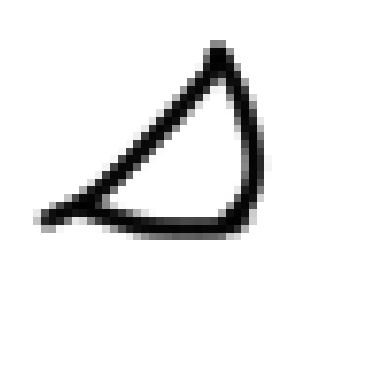

In [110]:
# rand_i = random.randint(0, len(X_test_normalized)-1)
# img_tensor, label = X_test_normalized[rand_i], y_test_augm_mix[rand_i]

image_content = tf.io.read_file('test_triangle.png')
image_tensor = tf.image.decode_png(image_content, channels=1)  # Use channels=1 for grayscale
img_tensor, label = tf.image.convert_image_dtype(image_tensor, tf.float32), 'triangle'

tensor_input = tf.expand_dims(img_tensor, 0)  # Add batch size dimension

# Make prediction
pred_logits = model.predict(tensor_input)
prediction = tf.nn.softmax(pred_logits)
probabilities = prediction.numpy()[0]*100
highest_choice = np.argmax(prediction)
pred_class = encoder_mappings[highest_choice]
print()

# predictions
print('                        ', end='')
for index, elem in enumerate(encoder_mappings):
    print(elem, end='    ')
print()

print('Confidence (percentage):', end=' ')
for prob in probabilities:
    print(f'{prob:<8.1f}', end=' ')
    #             <8.3f}
print()

print(f'Label: {label}, Prediction: {pred_class}')

plt.imshow(img_tensor.numpy(), cmap='gray')
plt.axis('off')  # Hide axes
plt.show()